## Importing Data from ADMA O/P FILE

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import yaml
import numpy as np

file_path = r'C:\Users\91971\Desktop\New folder\Dynamic_ADMA Data\2023-12-21 13-02-50\12-49-14_ADMA_w_BB2 x.xlsx'
ground_truth = pd.read_excel(file_path)

In [2]:
#Filtering the Data

gnss_time_week = ground_truth['GNSS_Time_Week']
gnss_time_msec = ground_truth['GNSS_Time_msec']
total_seconds = gnss_time_week * 604800 + gnss_time_msec / 1000
gnss_epoch = datetime.datetime(1980, 1, 6) #https://genesys-offenburg.de/support/tec-doc/data-output/admanet-data/admanet-list-of-data-packets-v3-3-5/

date_times = gnss_epoch + pd.to_timedelta(total_seconds, unit='s')

#ground_truth['GNSS_Date'] = date_times.dt.date
#ground_truth['GNSS_Time'] = date_times.dt.time
ground_truth['GNSS_Time'] = date_times

time_lat_long = ground_truth[['GNSS_Lat_Abs', 'GNSS_Long_Abs','INS_Lat_Abs','INS_Long_Abs','GNSS_Time']]
time_lat_long.head()


,GNSS_Lat_Abs,GNSS_Long_Abs,INS_Lat_Abs,INS_Long_Abs,GNSS_Time
0,48.755264,11.46497,48.755266,11.464971,2023-12-21 12:02:49.950000048
1,48.755264,11.46497,48.755266,11.464970,2023-12-21 12:02:50.000000000
2,48.755264,11.46497,48.755266,11.464970,2023-12-21 12:02:50.000000000
3,48.755264,11.46497,48.755266,11.464970,2023-12-21 12:02:50.000000000
4,48.755264,11.46497,48.755266,11.464971,2023-12-21 12:02:50.000000000


In [3]:
#time_lat_long.to_csv('/home/mewtwo/Desktop/Raahul/Dynamic data/dyn_adma_list.csv', index=False)

C:\Users\91971\AppData\Local\Temp\ipykernel_1428\3952892607.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_lat_long['Distance_From_Initial'] = time_lat_long.apply(calculate_distance_from_initial, axis=1)


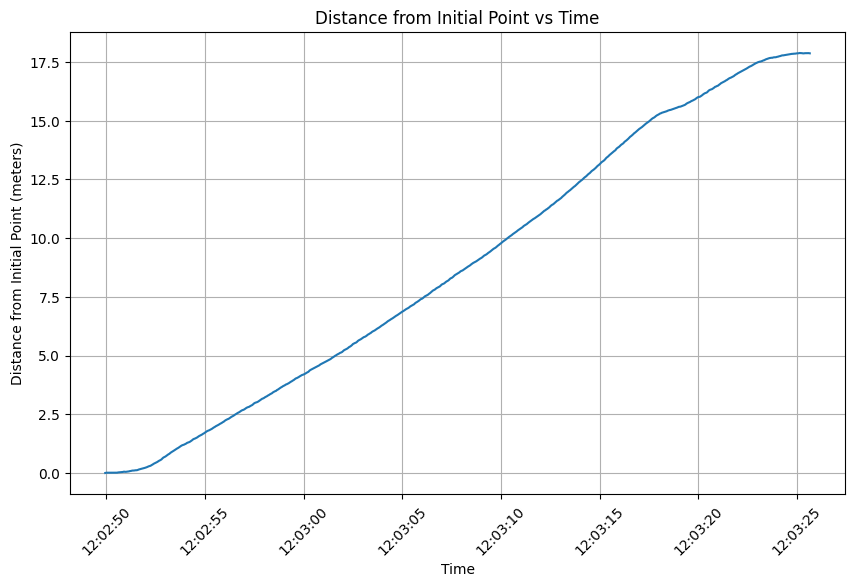

In [4]:
#Converting the coordinates to Cartesian form
from geopy.distance import geodesic

# Select the initial coordinates (first row in this case)
initial_coords = (time_lat_long.loc[0, 'GNSS_Lat_Abs'], time_lat_long.loc[0, 'GNSS_Long_Abs'])

# Calculate distance from initial point for each row
def calculate_distance_from_initial(row):
    coords = (row['GNSS_Lat_Abs'], row['GNSS_Long_Abs'])
    return geodesic(initial_coords, coords).meters

# Calculate distance from the initial point for each row
time_lat_long['Distance_From_Initial'] = time_lat_long.apply(calculate_distance_from_initial, axis=1)

# Plot the graph of distance from initial point vs time
plt.figure(figsize=(10, 6))
plt.plot(time_lat_long['GNSS_Time'], time_lat_long['Distance_From_Initial'])
plt.xlabel('Time')
plt.ylabel('Distance from Initial Point (meters)')
plt.title('Distance from Initial Point vs Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


## Making Data Frame for MAST measurements

In [5]:

file_path = r'C:\Users\91971\Desktop\New folder\Dynamic_ADMA Data\2023-12-21 13-02-50/Global_Obj_w_BB2.txt'

with open(file_path, 'r') as file:
    documents = yaml.safe_load_all(file)
    rows = []
    for document in documents:
        if document is not None and 'object_list' in document:
            for obj in document['object_list']:
                tracking_id = obj.get('tracking_id')
                obj_class = obj.get('obj_class')
                latitude_m = obj.get('obj_lat')
                longitude_m = obj.get('obj_lon')
                # Extracting time information
                timestamp = obj.get('timestamp')
                if timestamp:
                    time_secs = timestamp.get('secs')
                    time_nsecs = timestamp.get('nsecs')
                    if time_secs is not None and time_nsecs is not None:
                        # Convert to datetime
                        time = pd.to_datetime(time_secs + time_nsecs * 1e-9, unit='s')
                        # Extract date and time components
                        #date = time.date()
                        #time_of_day = time.time()
                        rows.append([tracking_id, obj_class, latitude_m, longitude_m, time])

columns = ['tracking_id', 'obj_class', 'Latitude_m', 'Longitude_m', 'Time']
mast_obj_list = pd.DataFrame(rows, columns=columns)
#mast_obj_list['Date'] = pd.to_datetime(mast_obj_list['Date'])
mast_obj_list.head()

,tracking_id,obj_class,Latitude_m,Longitude_m,Time
0,3,car,48.755061,11.471207,2023-12-21 12:01:23.704873472
1,3,car,48.755060,11.471234,2023-12-21 12:01:23.804895232
2,3,car,48.755059,11.471258,2023-12-21 12:01:23.904916736
3,3,car,48.755058,11.471283,2023-12-21 12:01:24.004938240
4,3,car,48.755057,11.471305,2023-12-21 12:01:24.104960000


In [6]:
mast_obj_list.tail()

,tracking_id,obj_class,Latitude_m,Longitude_m,Time
1083,3,car,48.755211,11.467819,2023-12-21 12:02:54.485268224
1084,1,person,48.755266,11.464711,2023-12-21 12:02:54.464203008
1085,2,car,48.755333,11.464877,2023-12-21 12:02:54.464203008
1086,4,car,48.755274,11.465232,2023-12-21 12:02:54.464203008
1087,3,car,48.755212,11.467798,2023-12-21 12:02:54.585289728


In [7]:
#Picking the test device detected by Mast

Test_Obj = mast_obj_list[(mast_obj_list['tracking_id'] == 1) & (mast_obj_list['obj_class'] == 'person')]
Test_Obj.head()


,tracking_id,obj_class,Latitude_m,Longitude_m,Time
11,1,person,48.755256,11.464975,2023-12-21 12:02:18.156354304
13,1,person,48.755256,11.464975,2023-12-21 12:02:18.256376320
15,1,person,48.755256,11.464975,2023-12-21 12:02:18.356397824
17,1,person,48.755256,11.464975,2023-12-21 12:02:18.456419584
19,1,person,48.755256,11.464975,2023-12-21 12:02:18.556441088


C:\Users\91971\AppData\Local\Temp\ipykernel_1428\3372406542.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Test_Obj['Distance_From_Initial'] = Test_Obj.apply(calculate_distance_from_initial, axis=1)


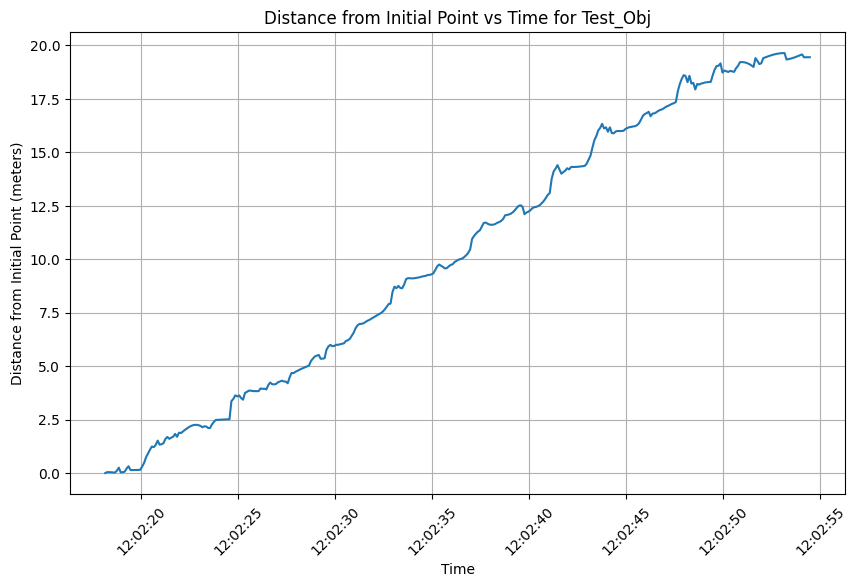

In [8]:
from geopy.distance import geodesic
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'Test_Obj' contains the DataFrame with object tracking information

# Select the initial coordinates (first row in this case)
initial_coords = (Test_Obj.iloc[0]['Latitude_m'], Test_Obj.iloc[0]['Longitude_m'])

# Calculate distance from initial point for each row in Test_Obj
def calculate_distance_from_initial(row):
    coords = (row['Latitude_m'], row['Longitude_m'])
    return geodesic(initial_coords, coords).meters

# Calculate distance from the initial point for each row in Test_Obj
Test_Obj['Distance_From_Initial'] = Test_Obj.apply(calculate_distance_from_initial, axis=1)

# Plot the graph of distance from initial point vs time for Test_Obj
plt.figure(figsize=(10, 6))
plt.plot(Test_Obj['Time'], Test_Obj['Distance_From_Initial'])
plt.xlabel('Time')
plt.ylabel('Distance from Initial Point (meters)')
plt.title('Distance from Initial Point vs Time for Test_Obj')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [9]:
#Exporting data to csv
#Test_Obj.to_csv('/home/mewtwo/Desktop/Raahul/Dynamic data/dyn_mast_obj_list.csv', index=False)

# Making closest time series match

In [10]:
threshold = 0.030000  # Threshold in seconds
result = []
previous_selected_time = None

for _, row in Test_Obj.iterrows():
    timestamp = row['Time']
    if previous_selected_time is None:
        # Find the nearest timestamp without any constraints
        nearest_time_idx = np.argmin(np.abs((time_lat_long['GNSS_Time'] - timestamp).dt.total_seconds()))
        nearest_row = time_lat_long.iloc[nearest_time_idx]
        previous_selected_time = nearest_row['GNSS_Time']
    else:
        if timestamp > previous_selected_time:
            # For subsequent selections, filter for future timestamps only if Test_Obj timestamp > previous selected time
            remaining_rows = time_lat_long[time_lat_long['GNSS_Time'] > previous_selected_time]
            if remaining_rows.empty:
                break  # Break if no future timestamps are available
        else:
            # If Test_Obj timestamp < previous selected time, find the nearest timestamp regardless of future or past
            nearest_time_idx = np.argmin(np.abs((time_lat_long['GNSS_Time'] - timestamp).dt.total_seconds()))
            nearest_row = time_lat_long.iloc[nearest_time_idx]
            previous_selected_time = nearest_row['GNSS_Time']
            continue
        
        nearest_time_idx = np.argmin(np.abs((remaining_rows['GNSS_Time'] - timestamp).dt.total_seconds()))
        nearest_row = remaining_rows.iloc[nearest_time_idx]
        previous_selected_time = nearest_row['GNSS_Time']
    
    time_diff = np.abs((nearest_row['GNSS_Time'] - timestamp).total_seconds())
    if time_diff > threshold:
        # If the time difference exceeds the threshold, leave the row blank
        pass
    else:
        result.append({
            'Test_Obj_Time': timestamp,
            'Nearest_GNSS_Time': nearest_row['GNSS_Time'],
            'Time_Difference': time_diff,  # Difference in timestamps
            'GNSS_Lat_Abs': nearest_row['GNSS_Lat_Abs'],
            'GNSS_Long_Abs': nearest_row['GNSS_Long_Abs'],
            'INS_Lat_Abs': nearest_row['INS_Lat_Abs'],
            'INS_Long_Abs': nearest_row['INS_Long_Abs'],
            'Latitude_m': row['Latitude_m'],
            'Longitude_m': row['Longitude_m'],
        })

nearest_time_table = pd.DataFrame(result).sort_values(by='Test_Obj_Time')
nearest_time_table.head()


,Test_Obj_Time,Nearest_GNSS_Time,Time_Difference,GNSS_Lat_Abs,GNSS_Long_Abs,INS_Lat_Abs,INS_Long_Abs,Latitude_m,Longitude_m
0,2023-12-21 12:02:50.063251712,2023-12-21 12:02:50.049999952,0.013252,48.755264,11.46497,48.755266,11.464970,48.755267,11.464720
1,2023-12-21 12:02:50.163273472,2023-12-21 12:02:50.150000095,0.013274,48.755264,11.46497,48.755266,11.464971,48.755267,11.464720
2,2023-12-21 12:02:50.263295232,2023-12-21 12:02:50.250000000,0.013296,48.755264,11.46497,48.755266,11.464971,48.755267,11.464721
3,2023-12-21 12:02:50.363316736,2023-12-21 12:02:50.349999905,0.013317,48.755264,11.46497,48.755266,11.464971,48.755267,11.464720
4,2023-12-21 12:02:50.463338496,2023-12-21 12:02:50.450000048,0.013339,48.755264,11.46497,48.755266,11.464971,48.755267,11.464720


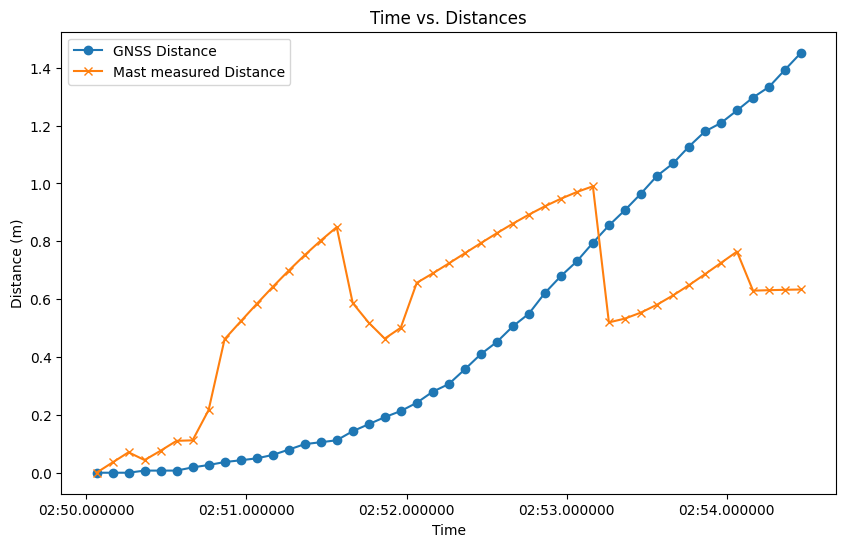

In [11]:
from geopy.distance import geodesic
import matplotlib.pyplot as plt

# Calculate distance between two coordinates
def calculate_distance(coord1, coord2):
    return geodesic(coord1, coord2).meters

# Selecting the first GNSS point as reference
reference_coords = (nearest_time_table.iloc[0]['GNSS_Lat_Abs'], nearest_time_table.iloc[0]['GNSS_Long_Abs'])

# Calculate GNSS distances from the first point
gnss_distances = [calculate_distance(reference_coords, (lat, lon)) for lat, lon in
                  zip(nearest_time_table['GNSS_Lat_Abs'], nearest_time_table['GNSS_Long_Abs'])]

# Calculate distances for Latitude_m and Longitude_m columns
reference_lat = nearest_time_table.iloc[0]['Latitude_m']
reference_lon = nearest_time_table.iloc[0]['Longitude_m']
lat_distances = [calculate_distance((reference_lat, reference_lon), (lat, lon)) for lat, lon in
                 zip(nearest_time_table['Latitude_m'], nearest_time_table['Longitude_m'])]

# Add calculated distances to the DataFrame
nearest_time_table['GNSS_Distance'] = gnss_distances
nearest_time_table['Lat_Long_Distance'] = lat_distances

# Plot both distances in a graph
plt.figure(figsize=(10, 6))
plt.plot(nearest_time_table['Test_Obj_Time'], nearest_time_table['GNSS_Distance'], label='GNSS Distance',marker='o')
plt.plot(nearest_time_table['Test_Obj_Time'], nearest_time_table['Lat_Long_Distance'], label='Mast measured Distance',marker='x')
plt.xlabel('Time')
plt.ylabel('Distance (m)')
plt.title('Time vs. Distances')
plt.legend()
plt.show()


In [12]:
#nearest_time_table.to_csv('/home/mewtwo/Desktop/Raahul/Static data/New_Merged_time_frames.csv', index=False)

## Error calculation

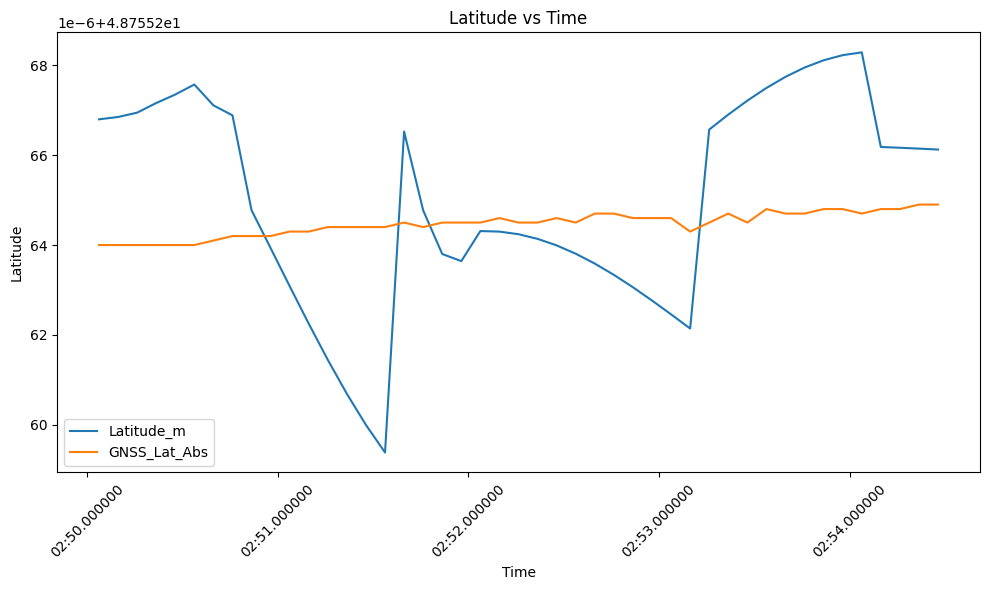

In [13]:
plt.figure(figsize=(10, 6))

# Plot Latitude_m over time
plt.plot(nearest_time_table['Test_Obj_Time'], nearest_time_table['Latitude_m'], label='Latitude_m')
plt.plot(nearest_time_table['Test_Obj_Time'], nearest_time_table['GNSS_Lat_Abs'], label='GNSS_Lat_Abs')

plt.xlabel('Time')
plt.ylabel('Latitude')
plt.title('Latitude vs Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


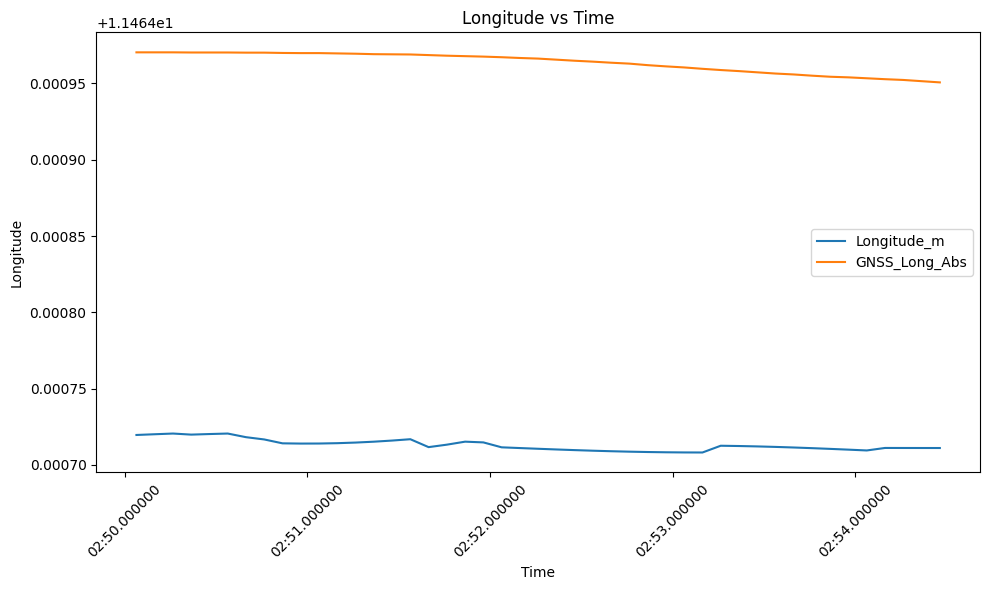

In [14]:
plt.figure(figsize=(10, 6))

# Plot Longitude_m over time
plt.plot(nearest_time_table['Test_Obj_Time'], nearest_time_table['Longitude_m'], label='Longitude_m')
plt.plot(nearest_time_table['Test_Obj_Time'], nearest_time_table['GNSS_Long_Abs'], label='GNSS_Long_Abs')

plt.xlabel('Time')
plt.ylabel('Longitude')
plt.title('Longitude vs Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
import geopy.distance

# Function to calculate distance between two coordinates in meters
def calc_distance(lat1, lon1, lat2, lon2):
    coords_1 = (lat1, lon1)
    coords_2 = (lat2, lon2)
    return geopy.distance.distance(coords_1, coords_2).meters

# Apply the function to create a new column for error in position in meters
nearest_time_table['Position_Error_m'] = nearest_time_table.apply(
    lambda row: calc_distance(
        row['GNSS_Lat_Abs'], 
        row['GNSS_Long_Abs'], 
        row['Latitude_m'], 
        row['Longitude_m']
    ),
    axis=1
)

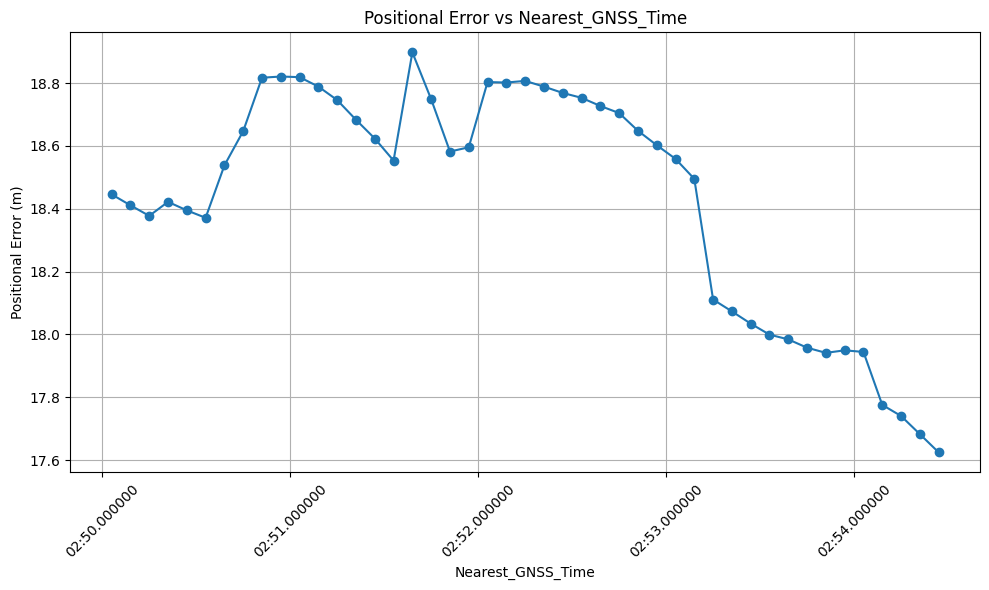

In [16]:
# Convert Nearest_GNSS_Time to datetime if it's not already in datetime format
#nearest_time_table['Nearest_GNSS_Time'] = pd.to_datetime(nearest_time_table['Nearest_GNSS_Time'])

# Plotting positional error against Nearest_GNSS_Time
plt.figure(figsize=(10, 6))
plt.plot(nearest_time_table['Nearest_GNSS_Time'], nearest_time_table['Position_Error_m'], marker='o', linestyle='-')
plt.title('Positional Error vs Nearest_GNSS_Time')
plt.xlabel('Nearest_GNSS_Time')
plt.ylabel('Positional Error (m)')
plt.xticks(rotation=45)  # Rotating x-axis labels for better readability
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()


### ERROR DISTRIBUTION

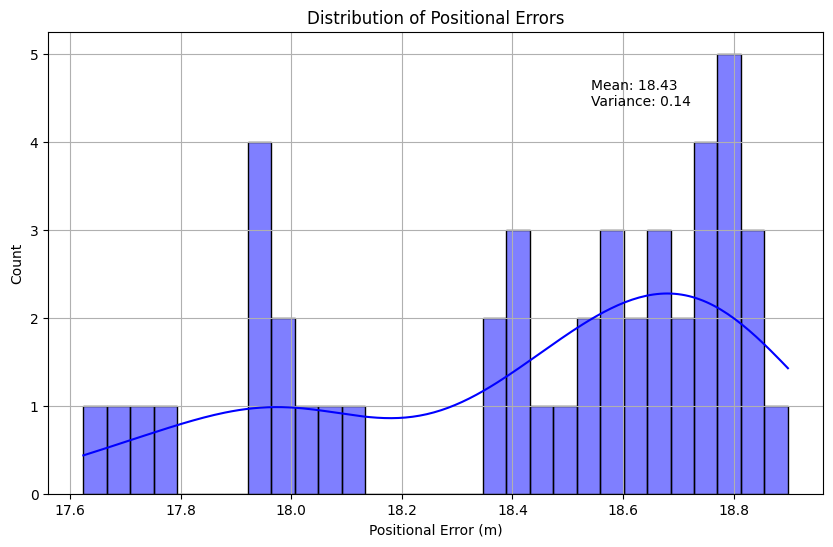

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

position_errors = nearest_time_table['Position_Error_m']

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(position_errors, bins=30, kde=True, color='blue', stat='count')

# Calculate mean and variance
mean_value = position_errors.mean()
variance_value = position_errors.var()

# Display mean and variance on the plot
plt.text(0.7, 0.9, f'Mean: {mean_value:.2f}\nVariance: {variance_value:.2f}', 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

# Customize the plot
plt.title('Distribution of Positional Errors')
plt.xlabel('Positional Error (m)')
plt.ylabel('Count')
plt.grid(True)
plt.show()


The complete formula for MOTA (Multiple Object Tracking Accuracy) involves several components and steps:

    False Positives (FP): These are the cases where a tracker provides a detection where there isn't any ground truth object.
    Misses (FN): These occur when a ground truth object isn't detected by the tracker.
    Mismatches: Cases where the tracker assigns a detection to a wrong ground truth object.
    Total Ground Truth (GT) Objects: The total number of ground truth objects.

## MISSES

In [18]:
nearest_time_table = nearest_time_table.sort_values(by='Test_Obj_Time')

# Set a threshold for missing detections (e.g., Timedelta('0 days 00:00:00.14'))
time_threshold = pd.Timedelta('0 days 00:00:00.12')

# Initialize counter and the initial time
misses_counter = 0
previous_time = None

# Iterate through the DataFrame to count misses
for index, row in nearest_time_table.iterrows():
    if previous_time is None:
        previous_time = row['Test_Obj_Time']
    else:
        time_diff = row['Test_Obj_Time'] - previous_time
        if time_diff > time_threshold:
            misses_counter += 1
        previous_time = row['Test_Obj_Time']

print("Number of misses:", misses_counter)


Number of misses: 0


## Mismatch 

In [19]:
# Set a positional threshold radius
positional_threshold = 1  # in meters

# Initialize counter for mismatches
mismatches_count = 0

# Count mismatches based on positional error
for index, row in nearest_time_table.iterrows():
    if row['Position_Error_m'] > positional_threshold:
        mismatches_count += 1

print("Number of mismatches:", mismatches_count)


Number of mismatches: 45


## MOTA 
##### MOTA = 1− ((Misses+FP+Mismatches+ID Switches)/Total GT Objects)​

In [20]:
total_gt_values = len(nearest_time_table)  # Total number of ground truth values

# Calculate MOTA
mota = 1 - ((misses_counter + mismatches_count) / total_gt_values)

print("MOTA:", mota)


MOTA: 0.0
